In [5]:
!pip uninstall numpy scipy pandas gensim -y
!pip install numpy==1.26.4 scipy pandas gensim


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylin

In [2]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 100.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Charger le modèle spaCy français
nlp = spacy.load("fr_core_news_sm")

df = pd.read_csv("/content/train (1).csv", encoding="utf-8")
df_test = pd.read_csv("/content/test (1).csv", encoding="utf-8")

# Vérifier les colonnes et créer la colonne `text` (titre + recette)
df.dropna(subset=['titre', 'recette', 'type'], inplace=True)
df['text'] = df['titre'] + " " + df['recette']
df_test['text'] = df_test['titre'] + " " + df_test['recette']

# Nettoyage du texte (tokenization + lemmatisation avec spaCy)
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

df['tokens'] = df['text'].apply(clean_text)
df_test['tokens'] = df_test['text'].apply(clean_text)

# Vérifier la répartition des classes
print(df['type'].value_counts())


type
Plat principal    5802
Dessert           3762
Entrée            2909
Name: count, dtype: int64


In [3]:
# Entraîner Word2Vec
word2vec_model = Word2Vec(sentences=df['tokens'],
                          vector_size=300,
                          window=5, min_count=1,
                          workers=4)
word2vec_model.save("word2vec_model.bin")

# Vérifier quelques mots
print(word2vec_model.wv.most_similar("saumon"))


[('fumé', 0.7944927215576172), ('pavé', 0.6722130179405212), ('truite', 0.6716110110282898), ('asperge', 0.6134769320487976), ('poisson', 0.6122062802314758), ('lescrevette', 0.5950573086738586), ('thon', 0.5948064923286438), ('épinard', 0.5823583006858826), ('darne', 0.5800009965896606), ('surimi', 0.5745980739593506)]


In [4]:
MAX_NB_WORDS = 5000  # Nombre max de mots
MAX_SEQUENCE_LENGTH = 100  # Longueur max d'une séquence

# Initialiser un tokenizer
tokenizer = Tokenizer(num_words=30_000, oov_token="<OOV>", filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df['text'])

# Convertir les textes en séquences
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index

# Appliquer un padding pour uniformiser la taille des séquences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encoder les labels
encoder = LabelEncoder()
df['type_encoded'] = encoder.fit_transform(df['type'])
y = to_categorical(df['type_encoded'])  # Encodage one-hot pour classification

# Convertir les textes en séquences en utilisant le tokenizer déjà entraîné
sequences_test = tokenizer.texts_to_sequences(df_test['text'])
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

df_test['type_encoded'] = encoder.transform(df_test['type'])
y_test = to_categorical(df_test['type_encoded'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
EMBEDDING_DIM = 300

# Créer la matrice d'embeddings
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Vérifier une embedding
print(embedding_matrix.shape)


(22599, 300)


In [6]:
# Vérifier la dimension des vecteurs Word2Vec
print("Dimension réelle des embeddings Word2Vec :", word2vec_model.vector_size)


Dimension réelle des embeddings Word2Vec : 300


In [7]:
# Construire le modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))  # On fige les embeddings Word2Vec

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
from tensorflow.keras.optimizers import Adam
model.compile(
    loss='categorical_crossentropy',  # Perte adaptée à la classification multi-classes
    optimizer=Adam(learning_rate=0.0001),  # Optimisation avec Adam et un taux d’apprentissage réduit
    metrics=['accuracy']  # Suivi de la précision pendant l’entraînement
)


In [9]:
history = model.fit(
    X_train, y_train,
    epochs=16,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4860 - loss: 1.0221 - val_accuracy: 0.7383 - val_loss: 0.6373
Epoch 2/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7717 - loss: 0.5559 - val_accuracy: 0.7844 - val_loss: 0.4721
Epoch 3/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8094 - loss: 0.4431 - val_accuracy: 0.8112 - val_loss: 0.4378
Epoch 4/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8232 - loss: 0.4074 - val_accuracy: 0.8120 - val_loss: 0.4176
Epoch 5/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8399 - loss: 0.3779 - val_accuracy: 0.8164 - val_loss: 0.4093
Epoch 6/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8363 - loss: 0.3729 - val_accuracy: 0.8257 - val_loss: 0.4065
Epoch 7/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8457 - loss: 0.3575 - val_accuracy: 0.8293 - val_loss: 0.4003
Epoch 8/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8524 - loss: 0.3497 - val_accuracy: 0.8257 - v

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


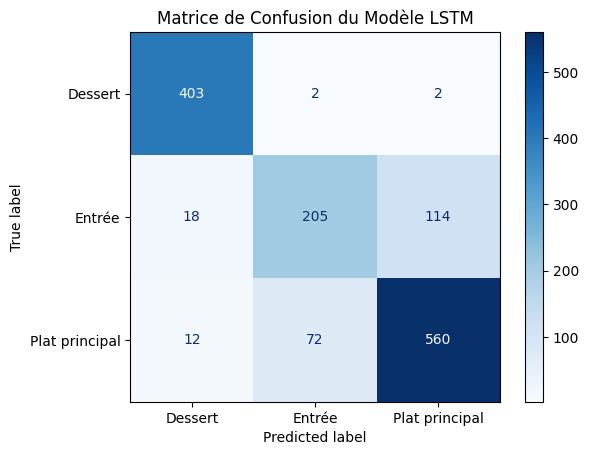

Test Accuracy: 84.15%

Rapport Détaillé :
                precision    recall  f1-score   support

       Dessert       0.93      0.99      0.96       407
        Entrée       0.73      0.61      0.67       337
Plat principal       0.83      0.87      0.85       644

      accuracy                           0.84      1388
     macro avg       0.83      0.82      0.82      1388
  weighted avg       0.84      0.84      0.84      1388



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # Ajouter ceci
import matplotlib.pyplot as plt

# Prédictions et évaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion du Modèle LSTM")
plt.show()

# Rapport de classification
print("Test Accuracy: {:.2f}%".format(acc * 100))
print("\nRapport Détaillé :")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))